In [184]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 
import scipy.misc
import pandas as pd
from glob import glob
from astropy.io import fits
from astropy.visualization import *
from photutils import *
import insight as ih

%matplotlib inline

### Calculating bias

In [2]:
#directories for the bias data
bias_directory_008 = 'data/darks/0.008'
bias_directory_009 = 'data/darks/0.009'

In [3]:
#biases for 0.008 s and 0.009 s exposures 
bias_008,std_008 = ih.bias_calc(bias_directory_008)
bias_009,std_009 = ih.bias_calc(bias_directory_009)

In [4]:
std_err_008 = std_008/np.sqrt(len(os.listdir(bias_directory_008)))
std_err_009 = std_009/np.sqrt(len(os.listdir(bias_directory_009)))

In [5]:
print('For exposure time of 0.008s the average bias is', bias_008)
print('Standard deviation', std_008)
print('Standard error',std_err_008)
print('For exposure time of 0.009s the average bias is', bias_009)
print('Standard deviation',std_009)
print('Standard error',std_err_009)

For exposure time of 0.008s the average bias is 766.3802704883889
Standard deviation 28.476783627343334
Standard error 5.199125585963244
For exposure time of 0.009s the average bias is 766.4963268640007
Standard deviation 28.424245044490817
Standard error 5.189533396974018


### Jupiter Data

In [6]:
jupiter_directory = 'data/jupiter'

In [7]:
jupiter_data = ih.multiple_fits(jupiter_directory)

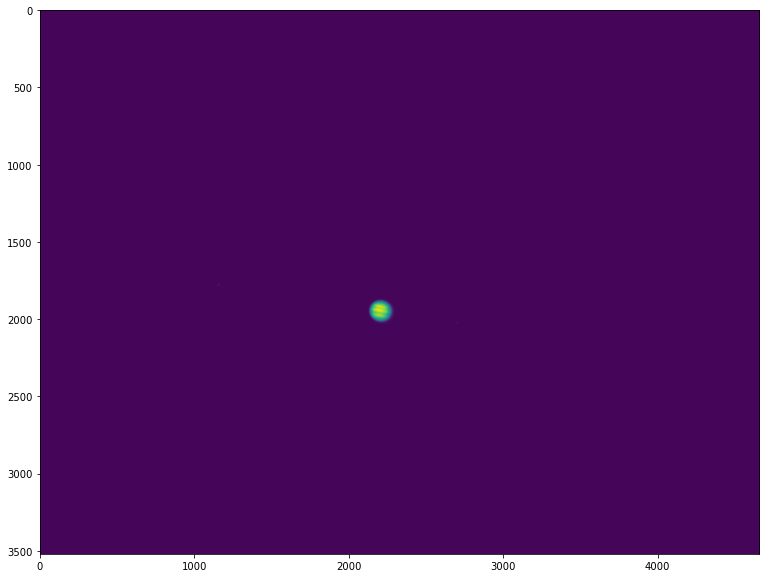

In [8]:
#the first image
plt.figure(figsize = (20,10))
plt.imshow(jupiter_data[0])

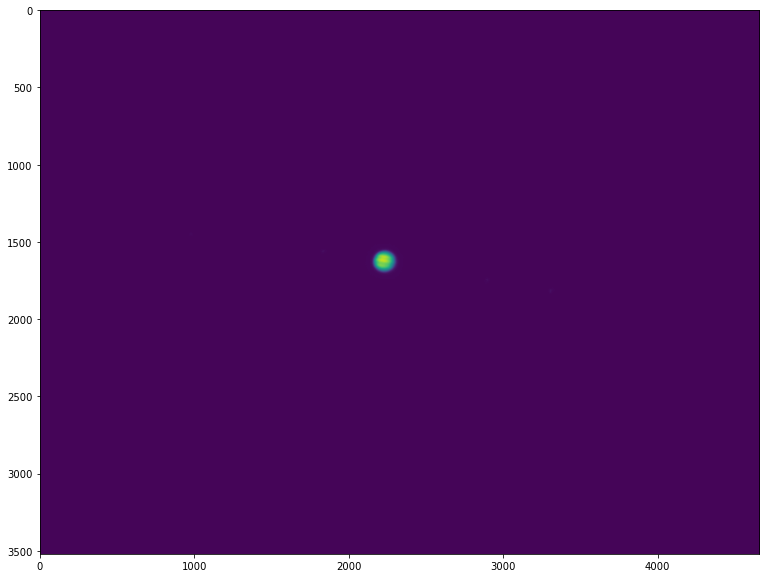

In [9]:
plt.figure(figsize = (20,10))
plt.imshow(jupiter_data[-1])

In [10]:
jupiter_data = jupiter_data - bias_008

In [11]:
#calculating the centroid of the reference image
x0, y0 = centroid_quadratic(jupiter_data[0], fit_boxsize = 1000)
print(x0,y0)

2198.6748305827 1941.4548058509636


In [12]:
centroids_x,centroids_y = ih.calculate_centroids(jupiter_data)

In [13]:
#calculating positional offsets compared to the reference image
xoffset =  -(centroids_x - x0)
yoffset =  -(centroids_y - y0)

In [14]:
xoffset

array([  32.95135038,   55.6734321 ,   74.96988243,  111.62709168,
        128.27346698,  156.25114497,  186.46214335,  218.37685254,
        264.1243004 ,  282.82268273,  300.50792316,  335.11586839,
        351.75151372,  363.35780234,  377.12516025,  386.65404679,
        390.48152795,  392.22020898,  386.23340337,  365.3923367 ,
        356.51082789,    3.53214988,   -6.07104912,  -15.27620796,
         -5.77550165,   -5.1241524 ,  -10.50905444,  -10.79450769,
         -8.11847115,  -14.64820369,  -20.29700889,   -5.9509626 ,
        -14.42441941,  -26.10995214,  -35.51003778,  -32.35055213,
        -43.80278315,  -74.18669608,  -92.04485863, -118.15001986,
       -143.35761826, -182.14268358, -212.76835093, -244.83377343,
        -86.79851759,  -77.69108859,  -48.24371739,  -23.06786257,
         -6.83694216,   28.07948086,   50.04596144,   75.56267896,
        110.73112754,  142.91221113,  170.1081043 ,  179.22673767,
         18.2895067 ,  -26.31796231,   -4.36300991,    1.34434

In [15]:
lintrans = ih.transformation_matrices(xoffset,yoffset)
lintrans[0]

array([[  1.        ,   0.        ,  32.95135038],
       [  0.        ,   1.        , -14.51444314]])

In [16]:
rows, cols = jupiter_data[0].shape[:2] 

In [80]:
new_jupiter_data_1 = ih.image_registration(jupiter_data[0:21],lintrans[0:21],rows,cols)

In [81]:
new_jupiter_data_2 = ih.image_registration(jupiter_data[22:41],lintrans[22:41],rows,cols)

In [82]:
new_jupiter_data_3 = ih.image_registration(jupiter_data[41:],lintrans[41:],rows,cols)

In [83]:
ref_img = np.array(jupiter_data[0])
ref_img.shape

(3520, 4656)

In [84]:
#getting out new dataset together
jupiter_centred_data = np.concatenate(([ref_img], new_jupiter_data_1,new_jupiter_data_2, new_jupiter_data_3))

In [85]:
jupiter_centred_data.shape

(65, 3520, 4656)

In [86]:
#uncomment if you need to write the centred images to .fits files
#name = 'jupiter'
#jupiter_centred = 'data/jupiter_centred'
#ih.write_to_fits(jupiter_centred,jupiter_centred_data,name)

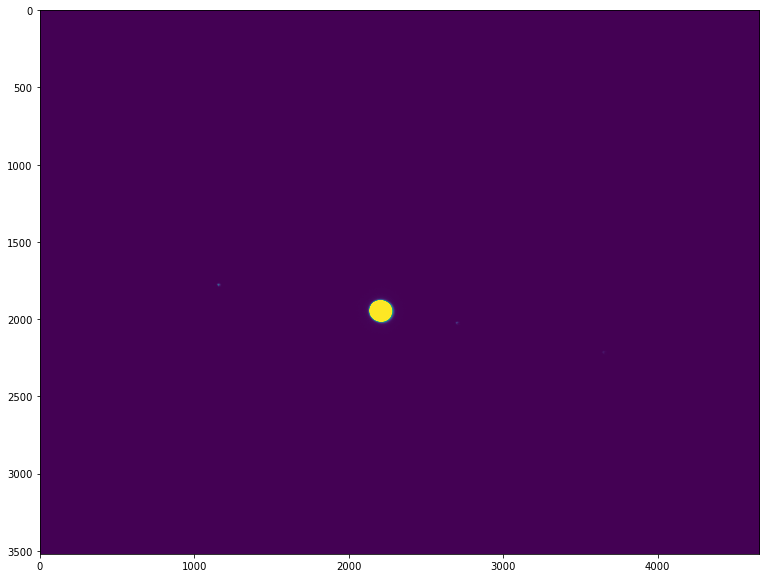

In [87]:
plt.figure(figsize = (20,10))
plt.imshow(jupiter_centred_data[0], vmin = 0, vmax = 10000)

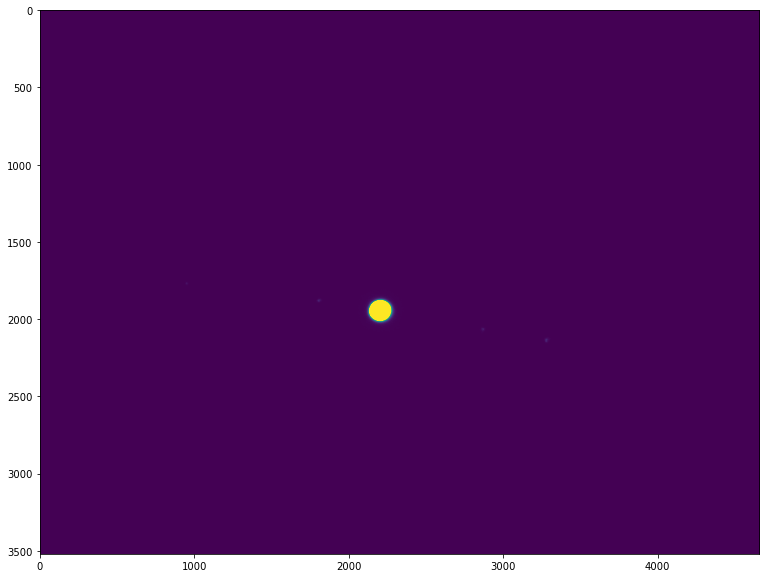

In [88]:
plt.figure(figsize = (20,10))
plt.imshow(jupiter_centred_data[-1],vmin = 0, vmax = 10000)

In [27]:
norm_1 = ih.norm_zscale_asinh(jupiter_centred_data)

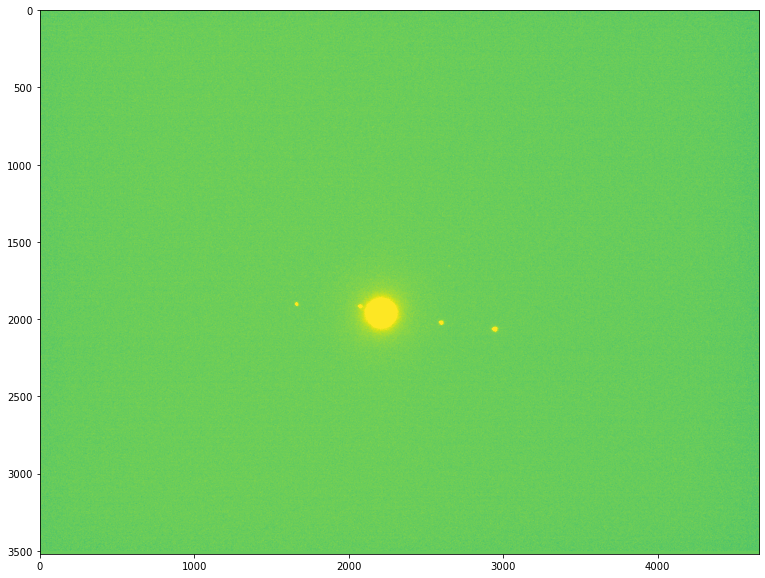

In [28]:
plt.figure(figsize = (20,10))
plt.imshow(jupiter_centred_data[21],norm=norm_1[21])

In [25]:
ZScaleInterval().get_limits(jupiter_centred_data[21])

(-133.42134574267726, 135.46828112285306)

### Finding the moons

In [273]:
#excluding Jupiter itself from sources detection
mask = np.zeros(jupiter_centred_data[0].shape, dtype=bool)
mask[1874:2014, 2127:2280] = True
norm = simple_norm(jupiter_centred_data[0], 'sqrt', percent=99.9)
#excluding random noise and stars
threshold = 1000

In [101]:
moons1 = ih.find_moons(jupiter_centred_data[0:21],mask,threshold)

In [102]:
moons2 = ih.find_moons(jupiter_centred_data[22:41],mask,threshold)

In [94]:
moons3 = ih.find_moons(jupiter_centred_data[42:],mask,threshold)

In [30]:
#index1 = (np.arange(0,len(moons1),1))
#index2 = (np.arange(len(moons1)+1,len(moons1)+1+len(moons2),1))
#index2

array([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197])

In [194]:
moons1_df = pd.DataFrame(moons1)
moons2_df = pd.DataFrame(moons2)
moons3_df = pd.DataFrame(moons3)
moons1_df.head()

x_peak  y_peak  peak_value
0    1154    1777  5217.61973
1    2696    2021  3697.61973
2    3644    2211  1121.61973
3    1159    1776  6742.61973
4    2705    2024  4029.11973

In [62]:
#moons1_df.to_csv (r'data/moons/moons_first.csv', index = False)

In [274]:
moons_joined = ih.find_moons(jupiter_centred_data,mask,threshold)
moons_joined_df = pd.DataFrame(moons_joined)

In [97]:
moons_joined_df.to_csv (r'data/moons/moons_joined.csv', index = False)

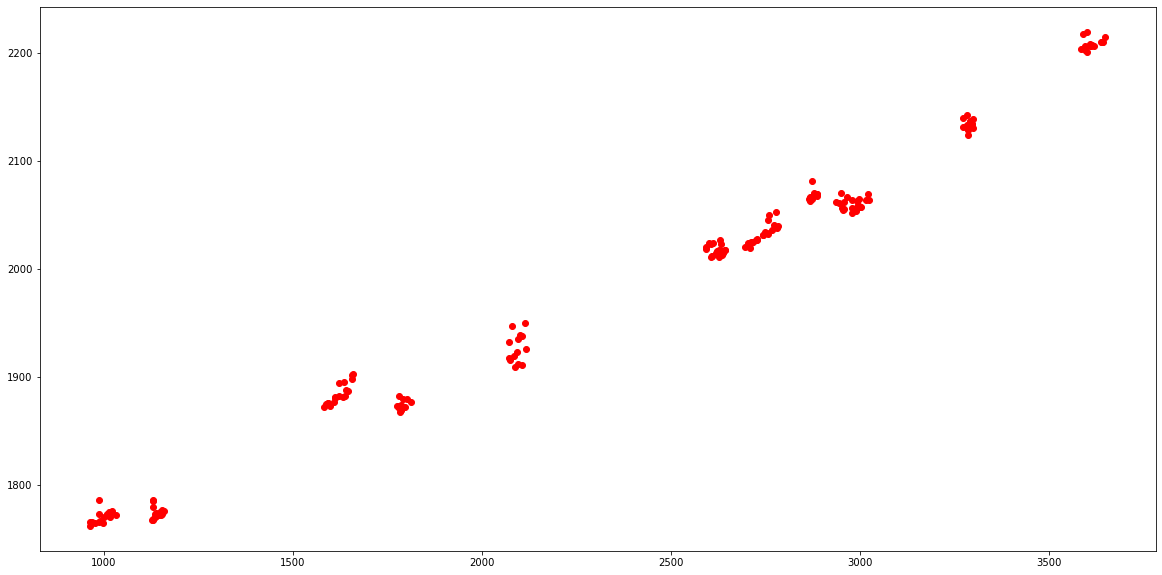

In [98]:
plt.figure(figsize = (20,10))
plt.scatter(moons_joined_df['x_peak'],moons_joined_df['y_peak'], color = 'red')

Need to find a way to identify which moon is which 

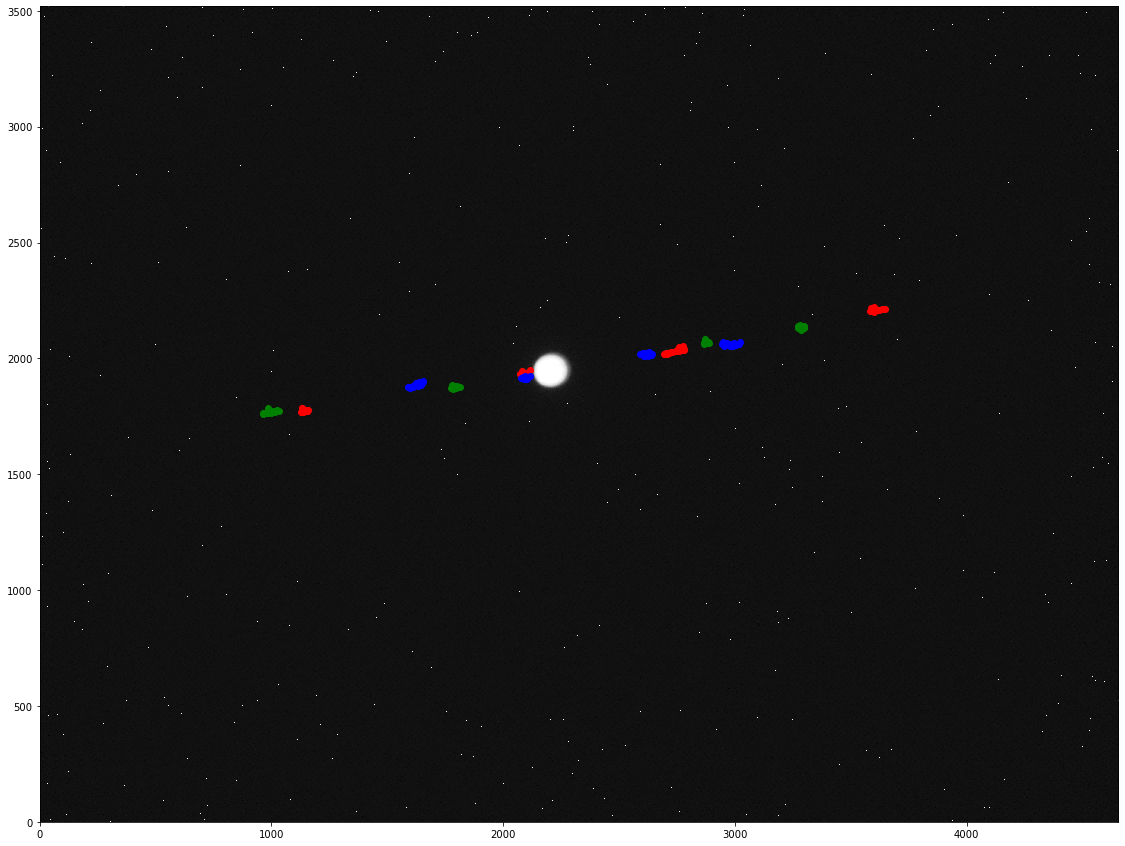

In [299]:
#old and new data together, red is the first set, blue is second set and green is the last set
plt.figure(figsize = (20,15))
plt.xlim(0, jupiter_centred_data[0].shape[1]-1)
plt.ylim(0, jupiter_centred_data[0].shape[0]-1)
plt.scatter(moons1_df['x_peak'],moons1_df['y_peak'], color = 'red')
plt.scatter(moons2_df['x_peak'],moons2_df['y_peak'], color = 'blue')
plt.scatter(moons3_df['x_peak'],moons3_df['y_peak'], color = 'green')
plt.imshow(jupiter_centred_data[0], cmap='Greys_r', origin='lower', norm=norm, interpolation='nearest')

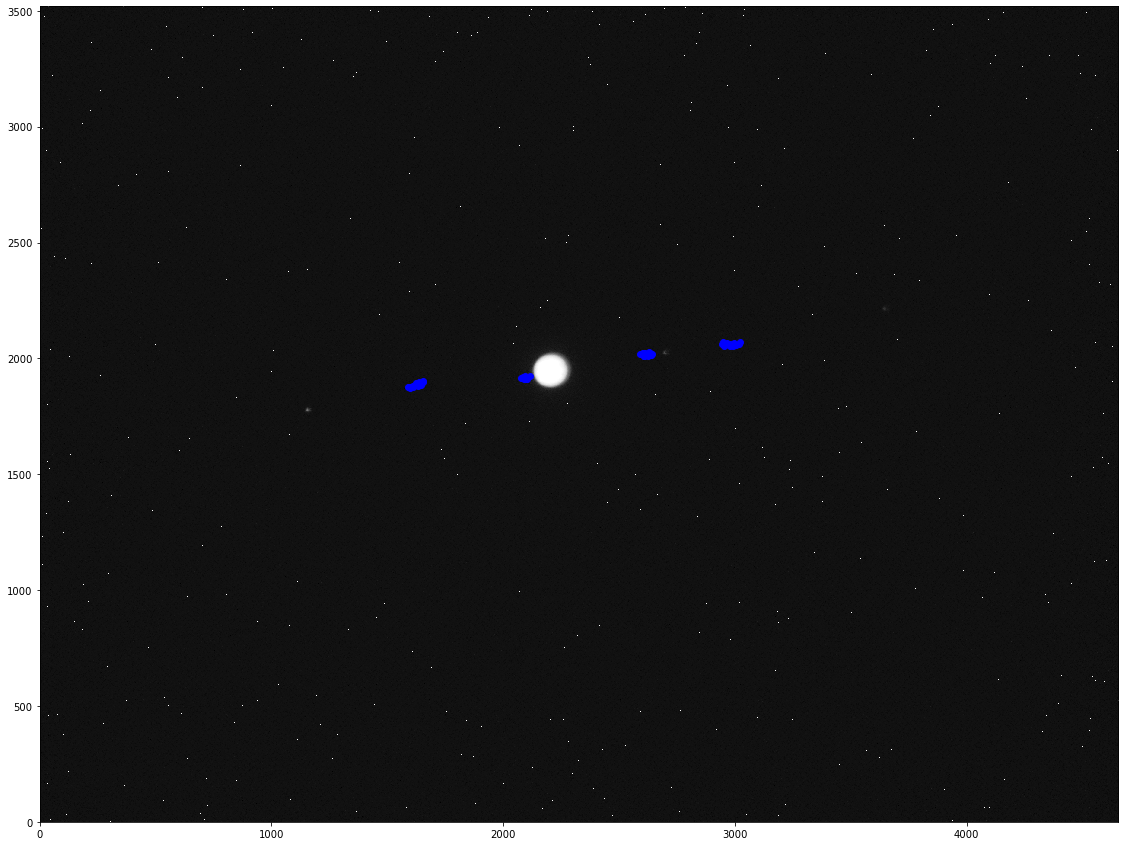

In [302]:
#second batch of data
plt.figure(figsize = (20,15))
plt.xlim(0, jupiter_centred_data[0].shape[1]-1)
plt.ylim(0, jupiter_centred_data[0].shape[0]-1)
plt.scatter(moons2_df['x_peak'],moons2_df['y_peak'], color = 'blue')
plt.imshow(jupiter_centred_data[0], cmap='Greys_r', origin='lower', norm=norm, interpolation='nearest')

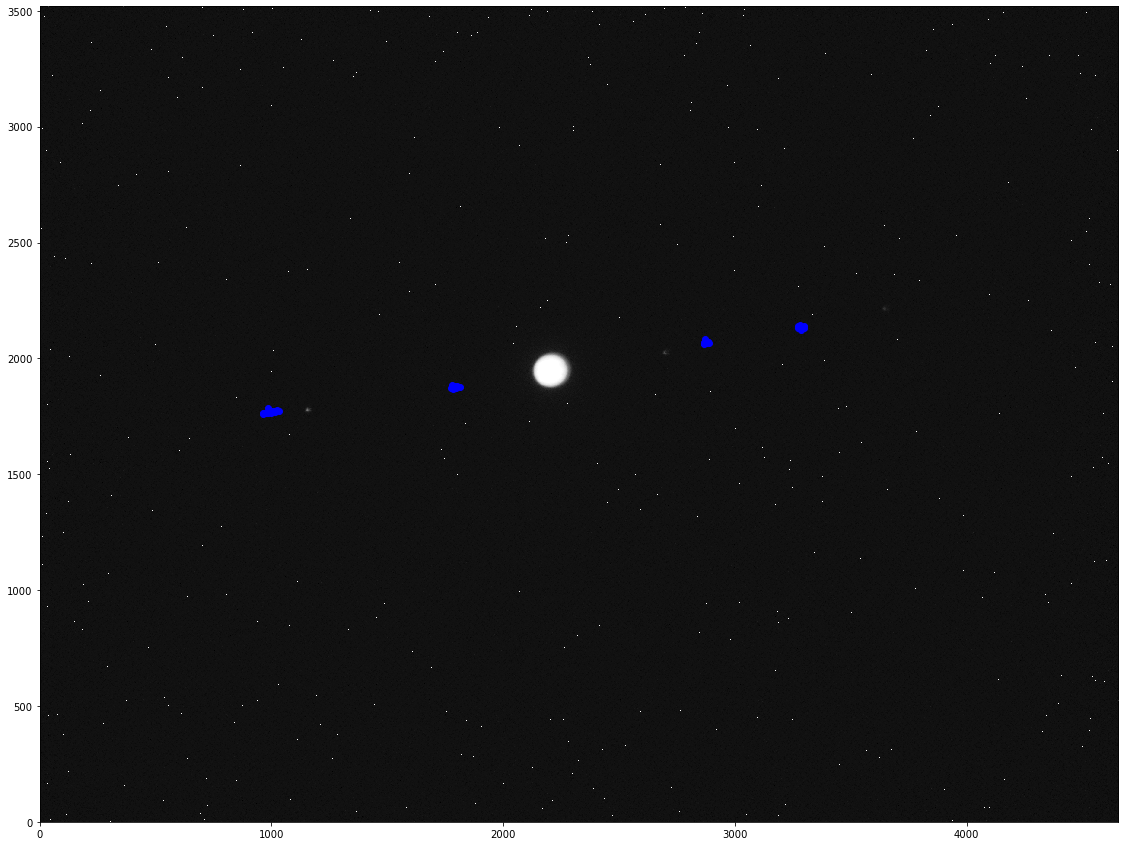

In [303]:
#third batch of data
plt.figure(figsize = (20,15))
plt.xlim(0, jupiter_centred_data[0].shape[1]-1)
plt.ylim(0, jupiter_centred_data[0].shape[0]-1)
plt.scatter(moons3_df['x_peak'],moons3_df['y_peak'], color = 'blue')
plt.imshow(jupiter_centred_data[0], cmap='Greys_r', origin='lower', norm=norm, interpolation='nearest')

In [312]:
#second batch of data, we cheated there a bit to assign specific datapoints to moons 
Moon_1_2 = np.array(moons2_df[moons2_df['x_peak'] > 2800])       
Moon_2_2 = np.array(moons2_df[moons2_df['x_peak'].between(2500, 2800)])
Moon_3_2 = np.array(moons2_df[moons2_df['x_peak'].between(2000, 2500)])
Moon_4_2 = np.array(moons2_df[moons2_df['x_peak'] < 2000])

In [313]:
cols = ['x_peak','y_peak','peak_value']
Moon_1_2_df = pd.DataFrame(Moon_1_2,columns = cols)
Moon_2_2_df = pd.DataFrame(Moon_2_2,columns = cols)
Moon_3_2_df = pd.DataFrame(Moon_3_2,columns = cols)
Moon_4_2_df = pd.DataFrame(Moon_4_2,columns = cols)

In [107]:
#only using the old data from 28/09/2020
Moon_1 = np.array(moons1_df[moons1_df['x_peak'] < 1800])       
Moon_2 = np.array(moons1_df[moons1_df['x_peak'].between(1800, 2400)])
Moon_3 = np.array(moons1_df[moons1_df['x_peak'].between(2400, 2800)])
Moon_4 = np.array(moons1_df[moons1_df['x_peak'] > 2800])

In [108]:
cols = ['x_peak','y_peak','peak_value']
Moon_1_df = pd.DataFrame(Moon_1,columns = cols)
Moon_2_df = pd.DataFrame(Moon_2,columns = cols)
Moon_3_df = pd.DataFrame(Moon_3,columns = cols)
Moon_4_df = pd.DataFrame(Moon_4,columns = cols)

In [305]:
#new data, we cheated there a bit to assign specific datapoints to moons 
Moon_1_3 = np.array(moons3_df[moons3_df['x_peak'] > 3100])       
Moon_2_3 = np.array(moons3_df[moons3_df['x_peak'].between(2000, 3100)])
Moon_3_3 = np.array(moons3_df[moons3_df['x_peak'].between(1500, 2000)])
Moon_4_3 = np.array(moons3_df[moons3_df['x_peak'] < 1500])

In [306]:
cols = ['x_peak','y_peak','peak_value']
Moon_1_3_df = pd.DataFrame(Moon_1_3,columns = cols)
Moon_2_3_df = pd.DataFrame(Moon_2_3,columns = cols)
Moon_3_3_df = pd.DataFrame(Moon_3_3,columns = cols)
Moon_4_3_df = pd.DataFrame(Moon_4_3,columns = cols)

In [314]:
Moon_1_join = pd.concat([Moon_1_df,Moon_1_2_df,Moon_1_3_df], ignore_index=True)
Moon_2_join = pd.concat([Moon_2_df,Moon_2_2_df,Moon_2_3_df], ignore_index=True)
Moon_3_join = pd.concat([Moon_3_df,Moon_3_2_df,Moon_3_3_df], ignore_index=True)
Moon_4_join = pd.concat([Moon_4_df,Moon_4_2_df,Moon_4_3_df], ignore_index=True)

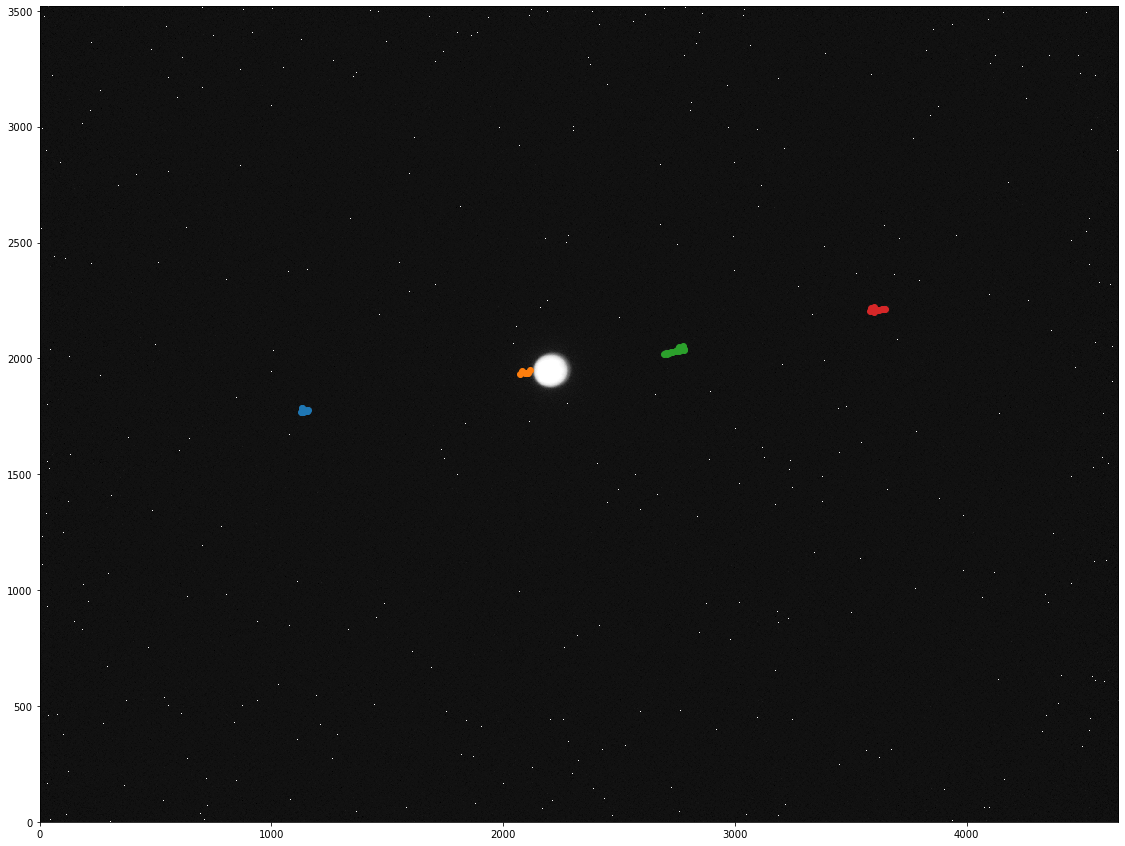

In [110]:
plt.figure(figsize = (20,15))
plt.xlim(0, jupiter_centred_data[0].shape[1]-1)
plt.ylim(0, jupiter_centred_data[0].shape[0]-1)
plt.scatter(Moon_1_df['x_peak'],Moon_1_df['y_peak'])
plt.scatter(Moon_2_df['x_peak'],Moon_2_df['y_peak'])
plt.scatter(Moon_3_df['x_peak'],Moon_3_df['y_peak'])
plt.scatter(Moon_4_df['x_peak'],Moon_4_df['y_peak'])
plt.imshow(jupiter_centred_data[0], cmap='Greys_r', origin='lower', norm=norm, interpolation='nearest')

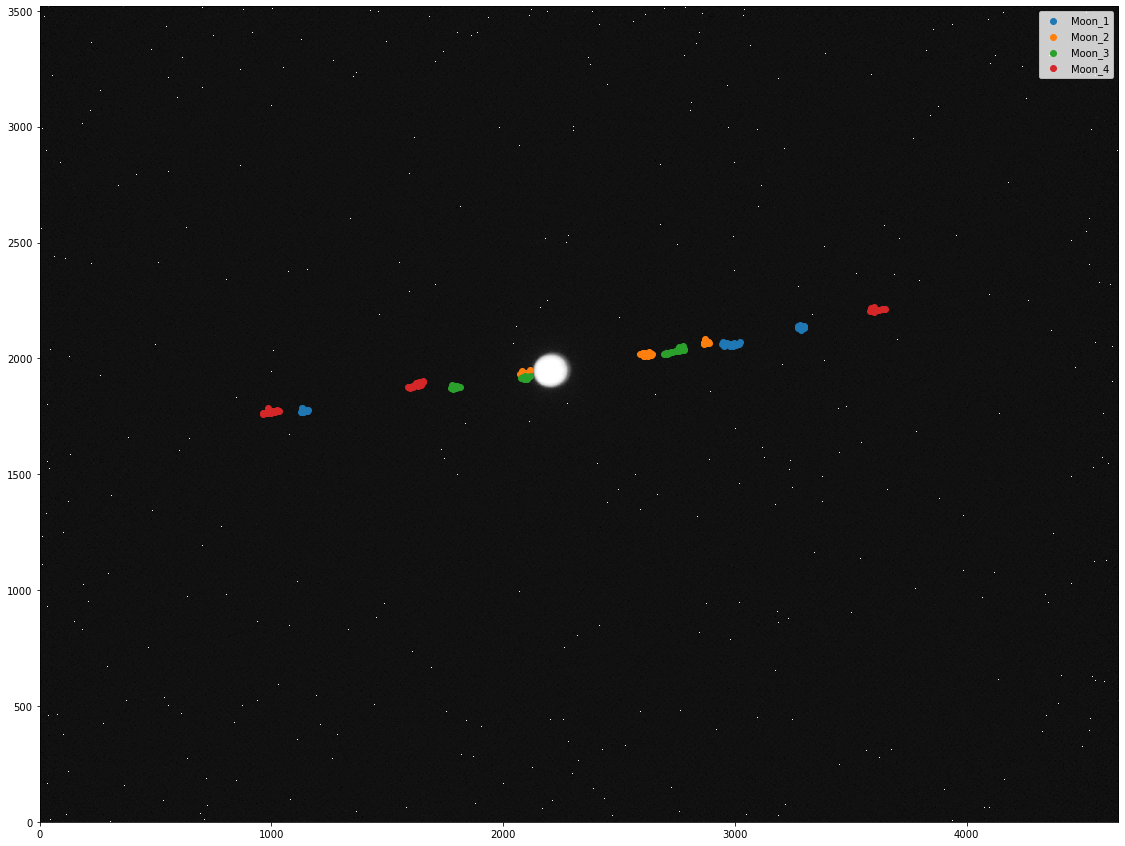

In [315]:
plt.figure(figsize = (20,15))
plt.xlim(0, jupiter_centred_data[0].shape[1]-1)
plt.ylim(0, jupiter_centred_data[0].shape[0]-1)
plt.scatter(Moon_1_join['x_peak'],Moon_1_join['y_peak'], label = 'Moon_1')
plt.scatter(Moon_2_join['x_peak'],Moon_2_join['y_peak'], label = 'Moon_2')
plt.scatter(Moon_3_join['x_peak'],Moon_3_join['y_peak'], label = 'Moon_3')
plt.scatter(Moon_4_join['x_peak'],Moon_4_join['y_peak'], label = 'Moon_4')
plt.imshow(jupiter_centred_data[0], cmap='Greys_r', origin='lower', norm=norm, interpolation='nearest')
plt.legend()

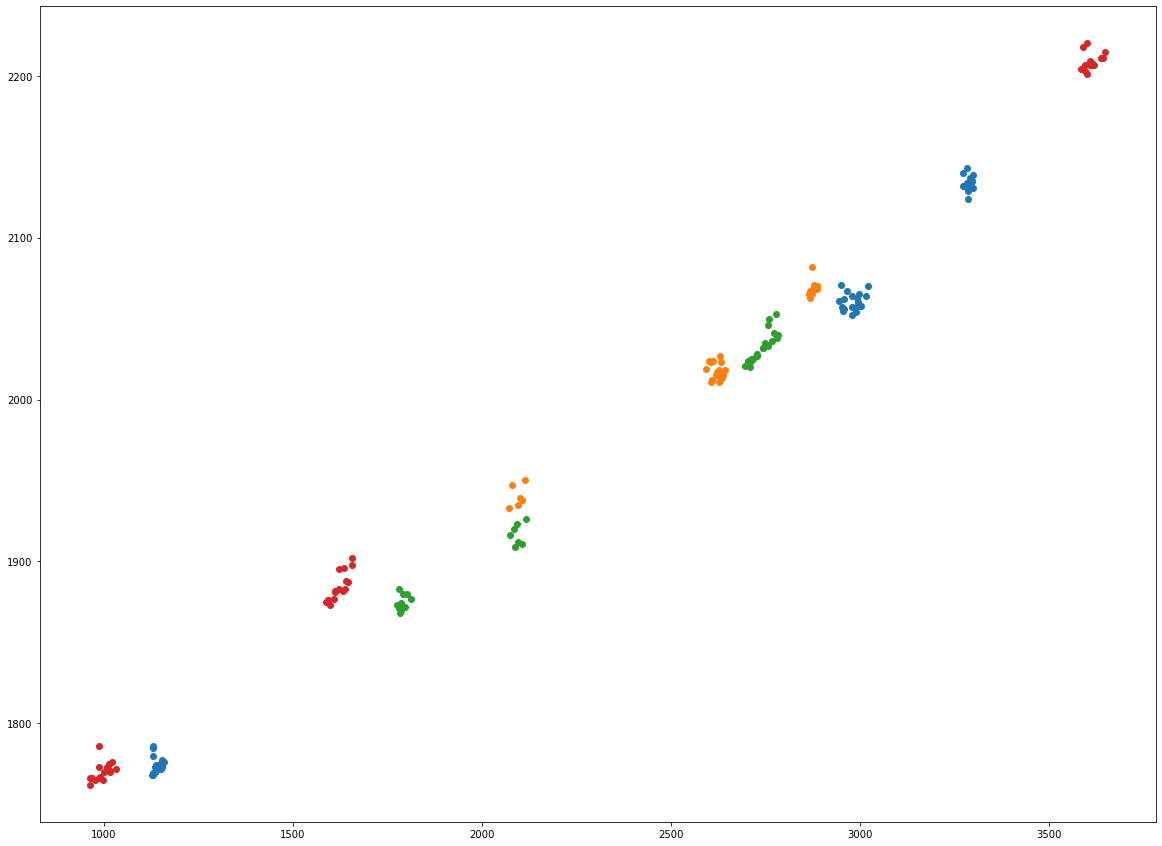

In [316]:
plt.figure(figsize = (20,15))
plt.scatter(Moon_1_join['x_peak'],Moon_1_join['y_peak'], label = 'Moon_1')
plt.scatter(Moon_2_join['x_peak'],Moon_2_join['y_peak'], label = 'Moon_2')
plt.scatter(Moon_3_join['x_peak'],Moon_3_join['y_peak'], label = 'Moon_3')
plt.scatter(Moon_4_join['x_peak'],Moon_4_join['y_peak'], label = 'Moon_4')

In [317]:
Moon_1_join['moon_name'] = 'Moon_1'
Moon_2_join['moon_name'] = 'Moon_2'
Moon_3_join['moon_name'] = 'Moon_3'
Moon_4_join['moon_name'] = 'Moon_4'

In [318]:
moon_12_joined = pd.concat([Moon_1_join,Moon_2_join,Moon_3_join,Moon_4_join])
moon_12_joined

x_peak  y_peak   peak_value moon_name
0   1154.0  1777.0  5217.619730    Moon_1
1   1159.0  1776.0  6742.619730    Moon_1
2   1154.0  1773.0  4533.057230    Moon_1
3   1153.0  1775.0  4708.400980    Moon_1
4   1152.0  1772.0  3606.619730    Moon_1
..     ...     ...          ...       ...
44   987.0  1766.0  1446.994730    Moon_4
45   977.0  1765.0  1258.104105    Moon_4
46   965.0  1762.0  1336.619730    Moon_4
47   969.0  1766.0  1107.604105    Moon_4
48   965.0  1766.0  1151.619730    Moon_4

[192 rows x 4 columns]

In [319]:
moon_12_joined.to_csv (r'data/moons/moon12_joined.csv', index = False)

In [320]:
Moon_1_join.to_csv (r'data/moons/moon1.csv', index = False)
Moon_2_join.to_csv (r'data/moons/moon2.csv', index = False)
Moon_3_join.to_csv (r'data/moons/moon3.csv', index = False)
Moon_4_join.to_csv (r'data/moons/moon4.csv', index = False)